In [1]:
import os
import sys
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import random
import gc
import pandas as pd
from collections import defaultdict


import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.nn.utils import weight_norm
# import torch.distributed as dist

# import torchopt
# import functorch

import higher

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

import shutil
if os.path.exists('checkpoints'):
    shutil.rmtree('checkpoints')

# __*Parameters*__

In [3]:
world_size = torch.cuda.device_count() ## Number of GPU's available

num_classes = 10                       ## Number of classes in the dataset
inner_loop_iterations = 32             ## Number of iterations in the inner training loop

LIM = 100                              ## Number of iterations in the outer loop

noise_size = 128                       ## Dimension of the noise vector used by the Generator
batch_size = 256                       ## Number of images in a batch in the inner loop

use_curriculum = True                  ## Enables Curriculum Learning

0


# __*Importing Data*__


In [5]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x)),
    transforms.ToTensor(),
#     torchvision.transforms.Resize((32,48),antialias=False),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# train = datasets.MNIST('../data', train=True, transform=transform, download=True)
# train, val = torch.utils.data.random_split(train, [50000, 10000])
# test = datasets.MNIST('../data', train=False, transform=transform, download=True)


train = datasets.CIFAR10('../data', train=True, transform=transform, download=True)
train, val = torch.utils.data.random_split(train, [inner_loop_iterations * batch_size, 50000 - inner_loop_iterations * batch_size])
test = datasets.CIFAR10('../data', train=False, transform=transform, download=True)

train = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True, drop_last=True)
val = torch.utils.data.DataLoader(val, batch_size = batch_size * 2, shuffle=True, drop_last=True)
test = torch.utils.data.DataLoader(test, batch_size = batch_size * 2, shuffle=True, drop_last=True)

steps_per_epoch = len(val)



Files already downloaded and verified
Files already downloaded and verified


In [9]:
import virtusagtn.GTN as vgtn
import virtusagtn.Models as Models

mylearners = [Models.Learner(img_size=[3,32,32], num_classes=10,
                cnn_filters = np.random.randint(low=32, high=256, size=(3,)),
                linear_filters = np.random.randint(low=32, high=128, size=(1,)))
                for i in range(LIM)]


In [10]:

mygtn = vgtn.TeacherGTN(loss_fn = nn.CrossEntropyLoss(),
                        learnerlist=mylearners, num_classes=10)

mygtn.train()

# __*Initialization*__

In [15]:
# use_teacher = False
# use_curriculum = True 

# params_to_train = []

# if use_teacher == True:
#     teacher = Teacher().to(device)
# #     teacher = nn.DataParallel(teacher, device_ids=list(range(torch.cuda.device_count())))
    
#     params_to_train += list(teacher.parameters())
#     if use_curriculum ==True:
#         teacher_noise = nn.Parameter(torch.randn(inner_loop_iterations, batch_size, noise_size), requires_grad=True) 
#         params_to_train += [teacher_noise]
    
#     teacher_labels = torch.arange(batch_size) % num_classes                        ## Creating Labels for Generator
#     one_hot = nn.functional.one_hot(teacher_labels, num_classes)                                        ## One hot encoding above labels
        
# else: 
#     curriculum_data=[]
#     curriculum_labels = []

#     for i in range(inner_loop_iterations):
#         loader = next(train_loader)
#         curriculum_data  +=[loader[0]]
#         curriculum_labels+=[loader[1]]

#     curriculum_data = nn.Parameter(torch.stack((curriculum_data),0).detach(),requires_grad=True)
#     curriculum_labels = torch.stack(curriculum_labels,0).detach()
#     params_to_train += [curriculum_data]

# optimizer_name = "sgd"
# optimizer_input = {'lr': 0.02, 'momentum':0.9}
# # optimizer_input = {'lr': 0.02}

    
# if optimizer_name == 'adam':
# #     ADAM: lr, weight_decay, amsgrad, betas
#     default_optimizer = optim.Adam
    
# if optimizer_name == 'sgd':
#     #  SGD: lr, weight_decay, momentum, dampening, nesterov
#     default_optimizer = optim.SGD

# optim_params = [nn.Parameter(Tensor(x).to(device)) if isinstance(x,list) else nn.Parameter(Tensor([x]).to(device))  for x in optimizer_input.values()]     
# # optim_params = nn.Parameter(Tensor(list(optimizer_input.values())).to(device), requires_grad=True)                          ## Parameters for SGD optimizer are also learnt 
# params_to_train += optim_params


# optimizer_teacher = optim.Adam(params_to_train,0.002, [0.9,0.9])                                                           ## Optimizer for Generator
# loss_fn = nn.CrossEntropyLoss()                                                                                ## Loss Fn used by the Learner

# epochs = 1
# plot_steps = 25
# batch_exe = 4         
# def divide_chunks(l, n):
#     for i in range(0, len(l), n): 
#         yield l[i:i + n]
  
# batches = list(divide_chunks(list(range(inner_loop_iterations)), batch_exe))

# path='./checkpoints'
# if not os.path.exists(path):
#     os.makedirs(path)

# __*GTN Training Loop*__

In [18]:
# if use_teacher == True:
#     curriculum_data=[]
#     curriculum_labels=[]
#     with torch.no_grad():
#         for step in range(inner_loop_iterations):
#             curriculum_data += [teacher(teacher_noise[step].to(device),one_hot.to(device)).detach()]
#             curriculum_labels += [teacher_labels]
#             curriculum_data[step].requires_grads = False
#             plot_results(curriculum_data[step])
            
#         curriculum_data = nn.Parameter(torch.stack((curriculum_data),0).detach(),requires_grad=False)

# __*Results*__

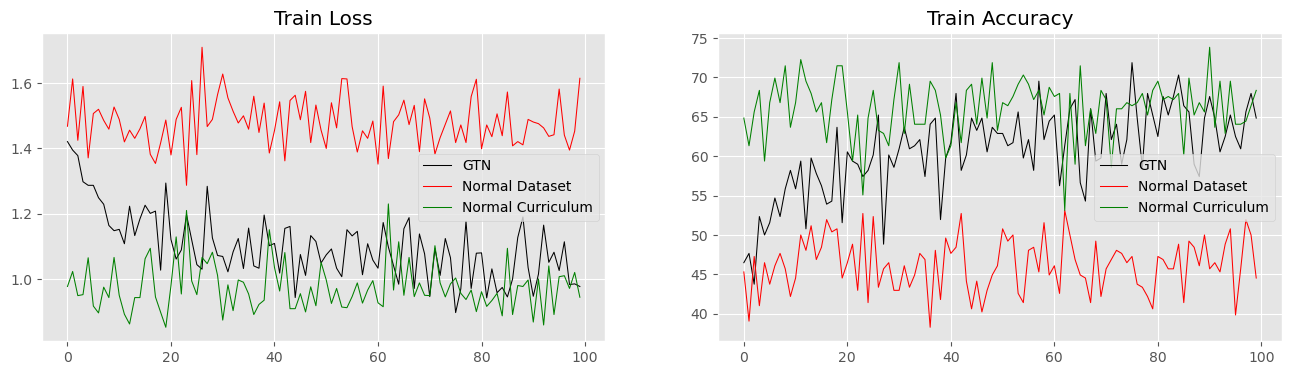

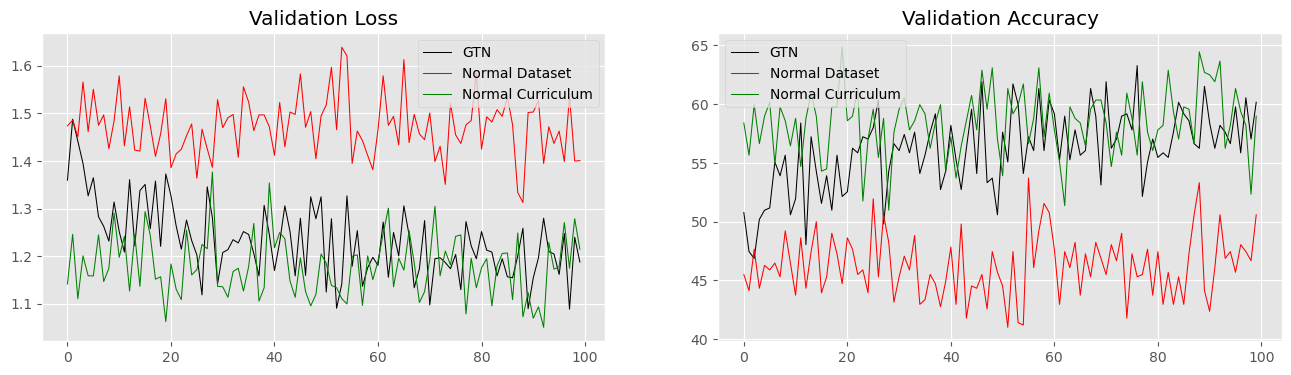

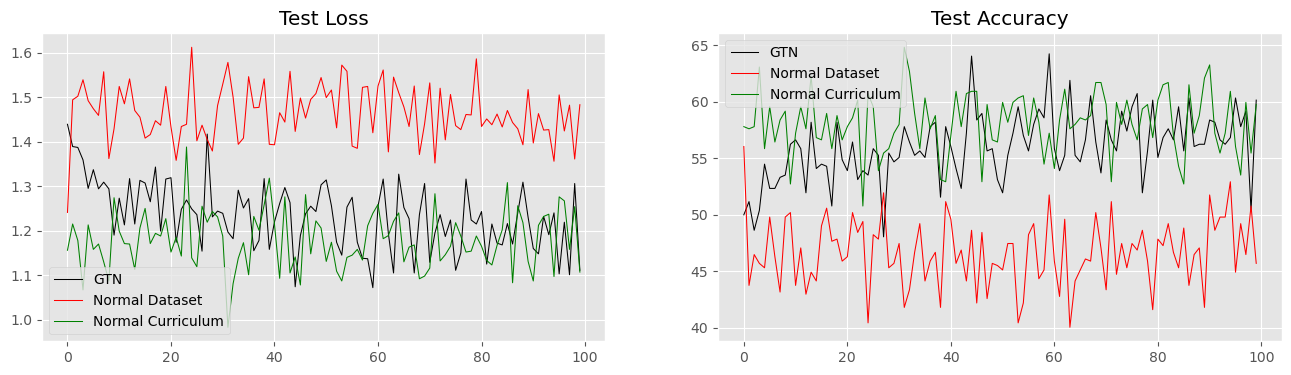

In [38]:
# plt.style.use('ggplot')
# plt.rcParams["figure.figsize"] = (16,4)


# plt.subplot(1,2,1)
# plt.plot(range(LIM),gtn["Train Loss"].apply(lambda x:x[-1]),              label="GTN",              linewidth=0.75, color="black")
# plt.plot(range(LIM),normaldataset["Train Loss"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color="red")
# plt.plot(range(LIM),normalcurriculum["Train Loss"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color="green")
# # plt.plot(range(LIM),gtncurriculum["Train Loss"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color="blue")
# # plt.plot(range(LIM),gtndataset["Train Loss"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color="gray")
# plt.title("Train Loss")
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(range(LIM),gtn["Train Accuracy"].apply(lambda x:x[-1]),              label= "GTN",             linewidth=0.75, color= "black")
# plt.plot(range(LIM),normaldataset["Train Accuracy"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color= "red")
# plt.plot(range(LIM),normalcurriculum["Train Accuracy"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color= "green")
# # plt.plot(range(LIM),gtncurriculum["Train Accuracy"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color= "blue")
# # plt.plot(range(LIM),gtndataset["Train Accuracy"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color= "gray")

# plt.title("Train Accuracy")
# plt.legend()
# plt.show()

# plt.subplot(1,2,1)
# plt.plot(range(LIM),gtn["Validation Loss"].apply(lambda x:x[-1]),              label="GTN",              linewidth=0.75, color="black")
# plt.plot(range(LIM),normaldataset["Validation Loss"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color="red")
# plt.plot(range(LIM),normalcurriculum["Validation Loss"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color="green")
# # plt.plot(range(LIM),gtncurriculum["Validation Loss"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color="blue")
# # plt.plot(range(LIM),gtndataset["Validation Loss"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color="gray")
# plt.title("Validation Loss")
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(range(LIM),gtn["Validation Accuracy"].apply(lambda x:x[-1]),              label= "GTN",             linewidth=0.75, color= "black")
# plt.plot(range(LIM),normaldataset["Validation Accuracy"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color= "red")
# plt.plot(range(LIM),normalcurriculum["Validation Accuracy"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color= "green")
# # plt.plot(range(LIM),gtncurriculum["Validation Accuracy"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color= "blue")
# # plt.plot(range(LIM),gtndataset["Validation Accuracy"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color= "gray")
# plt.title("Validation Accuracy")
# plt.legend()
# plt.show()

# plt.subplot(1,2,1)
# plt.plot(range(LIM),gtn["Test Loss"].apply(lambda x:x[-1]),              label="GTN",              linewidth=0.75, color="black")
# plt.plot(range(LIM),normaldataset["Test Loss"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color="red")
# plt.plot(range(LIM),normalcurriculum["Test Loss"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color="green")
# # plt.plot(range(LIM),gtncurriculum["Test Loss"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color="blue")
# # plt.plot(range(LIM),gtndataset["Test Loss"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color="gray")
# plt.title("Test Loss")
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(range(LIM),gtn["Test Accuracy"].apply(lambda x:x[-1]),              label= "GTN",             linewidth=0.75, color= "black")
# plt.plot(range(LIM),normaldataset["Test Accuracy"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color= "red")
# plt.plot(range(LIM),normalcurriculum["Test Accuracy"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color= "green")
# # plt.plot(range(LIM),gtncurriculum["Test Accuracy"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color= "blue")
# # plt.plot(range(LIM),gtndataset["Test Accuracy"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color= "gray")
# plt.title("Test Accuracy")
# plt.legend()
# plt.show()

# # plt.tight_layout()
